# AI chatbot for depression detection

### Importing modules

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import seaborn as sns

### Gathering data

In [2]:
df = pd.read_csv('data.csv')
# Standarize columns names
df = df.rename(columns={'clean_text': 'text', 'is_depression':'label'})

In [3]:
df.head()

,text,label
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [4]:
df.shape

(7731, 2)

### Preprocessing and tokenizing data

In [5]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer() 
# downoload dependencies

def preprocess(sentence):
    
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) in range(3,14) if not w in stopwords.words('english')]
#     stem_words=[stemmer.stem(w) for w in filtered_words]
#     lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]

    # return None is sentence have only one word
    if " ".join(filtered_words).count(" ") == 0: return
    return " ".join(filtered_words)


df['clean_text'] = df['text'].map(lambda s:preprocess(s)) 

In [7]:
# dropping empty rows
df = df.dropna()
df.head()

,text,label,clean_text
0,we understand that most people who reply immed...,1,understand people reply immediately invitation...
1,welcome to r depression s check in post a plac...,1,welcome depression check post place take momen...
2,anyone else instead of sleeping more when depr...,1,anyone else instead sleeping depressed stay ni...
3,i ve kind of stuffed around a lot in my life d...,1,kind stuffed around lot life delaying inevitab...
4,sleep is my greatest and most comforting escap...,1,sleep greatest comforting escape whenever wake...


### Stemming data

In [8]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

def stemming(sentence):
    
    stem_sentence = [ps.stem(word) for word in sentence.split()]
    return ' '.join(stem_sentence)

df['stem_text'] = df['clean_text'].map(lambda s:stemming(s)) 

In [9]:
df.head()

,text,label,clean_text,stem_text
0,we understand that most people who reply immed...,1,understand people reply immediately invitation...,understand peopl repli immedi invit talk priva...
1,welcome to r depression s check in post a plac...,1,welcome depression check post place take momen...,welcom depress check post place take moment sh...
2,anyone else instead of sleeping more when depr...,1,anyone else instead sleeping depressed stay ni...,anyon els instead sleep depress stay night avo...
3,i ve kind of stuffed around a lot in my life d...,1,kind stuffed around lot life delaying inevitab...,kind stuf around lot life delay inevit work jo...
4,sleep is my greatest and most comforting escap...,1,sleep greatest comforting escape whenever wake...,sleep greatest comfort escap whenev wake day l...


In [10]:
df.to_csv('stem_data.csv')

In [11]:
longest_tweet = 0
sentences_len = []
for sentence in df['stem_text']: 
    sentence_len = " ".join(sentence.split()).count(" ")
    sentences_len.append(sentence_len)
    if longest_tweet < sentence_len:
        longest_tweet = sentence_len
longest_tweet

1782

Longest tweet in this dataset contains 1785 words.

<AxesSubplot:ylabel='Frequency'>

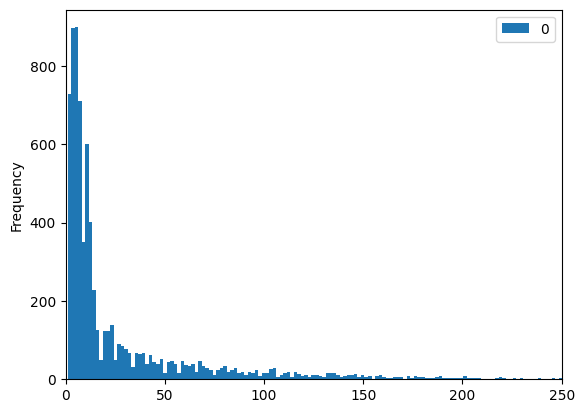

In [12]:
pd.DataFrame(sentences_len).plot.hist(bins=1000, grid=False, xlim=(0,250))

Distribution of length of data(limited to 250).

Average length of tweet:

In [13]:
avg = np.average(np.asarray(sentences_len))
avg

32.072319201995015

Dominant length:

In [14]:
counts = np.bincount(np.asarray(sentences_len))
np.argmax(counts)

5

Std of this array:

In [15]:
std = np.std(np.asarray(sentences_len))
std

61.12474163690561

I will assume standard length as 155

In [16]:
standard_len = int(np.ceil(avg + 2*std))
standard_len

155

### Counting words

In [21]:
counts = df["stem_text"].str.findall(r"(\w+)").explode().value_counts()
# counts = counts.nlargest(10)

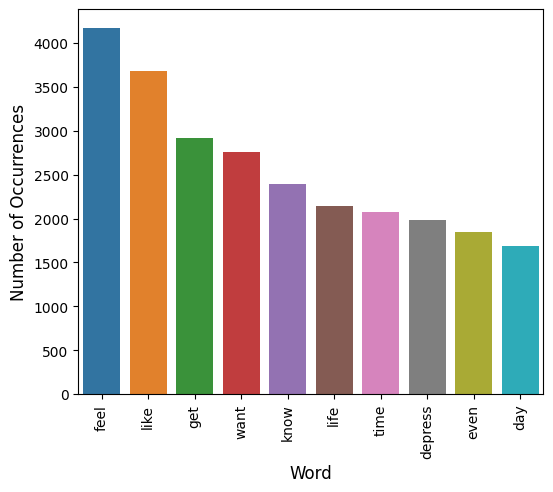

In [20]:
fig, ax = plt.subplots(figsize=(6,5))
sns.barplot(x=counts.index, y=counts.values, ax=ax)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
ax.xaxis.set_tick_params(rotation=90)

In [24]:
len(counts)

14138

There is 14138 word in this dataset

In [47]:
for idx, freq in enumerate(counts):
    if freq < 5:
        print(idx)
        break

3440


Only 3440 first word occurent more than 4 times in this dataset

### Vectorizing words

In [48]:
from nltk import word_tokenize
from collections import defaultdict

def count_top_x_words(corpus, top_x, skip_top_n):
    count = defaultdict(lambda: 0)
    for c in corpus:
        for w in word_tokenize(c):
            count[w] += 1
    count_tuples = sorted([(w, c) for w, c in count.items()], key=lambda x: x[1], reverse=True)
    return [i[0] for i in count_tuples[skip_top_n: skip_top_n + top_x]]


def replace_top_x_words_with_vectors(corpus, top_x):
    topx_dict = {top_x[i]: i for i in range(len(top_x))}

    return [
        [topx_dict[w] for w in word_tokenize(s) if w in topx_dict]
        for s in corpus
    ], topx_dict


def filter_to_top_x(corpus, n_top, skip_n_top=0):
    top_x = count_top_x_words(corpus, n_top, skip_n_top)
    return replace_top_x_words_with_vectors(corpus, top_x)

In [49]:
text_list = df['stem_text'].tolist()
number_of_words = 3440
mapped_list, word_list = filter_to_top_x(text_list, number_of_words)

In [50]:
# mapped_list
list(word_list)[0:5]

['feel', 'like', 'get', 'want', 'know']

### Creating training and testing dataset

In [51]:
tf.random.set_seed(
                seed=0
)

In [52]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import normalize

labels = np.asarray(df['label'].tolist()).astype('float64')

max_text_length = standard_len # based on the statistic deviation
mapped_list = sequence.pad_sequences(mapped_list, maxlen=max_text_length)

# mapped_list = normalize(
#     mapped_list, axis=-1, order=2
# )

# Instead normalizing by division
mapped_list = mapped_list / 3440

x_train, x_test, y_train, y_test = train_test_split(mapped_list, labels, test_size=0.3)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

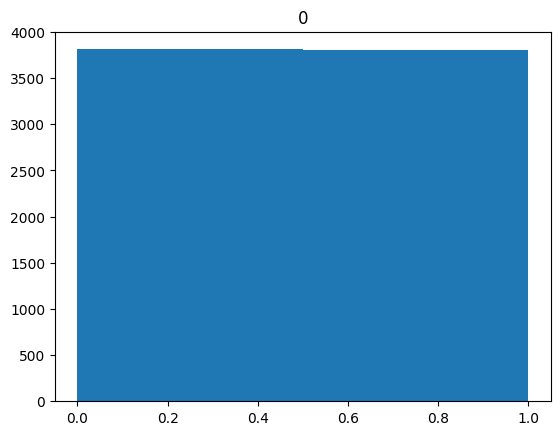

In [53]:
pd.DataFrame(labels).hist(bins=2, grid=False)

Dataset is extremely balanced

In [54]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### Creating machine learning model

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, InputLayer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam

In [56]:
 class my_model:
    
    def __init__(self, embedding=0, ker=0, pool_size=0, strides=0, input_shape=0):
        
        self.embedding = embedding
        self.ker = ker
        self.pool_size = pool_size
        self.strides = strides
        self.input_shape = input_shape
        
        
    def cnn(self):

        model = Sequential()

        model.add(Embedding(number_of_words, self.embedding, input_length=max_text_length))
        model.add(Conv1D(self.ker, self.ker))
        model.add(MaxPooling1D(pool_size=self.pool_size, strides=self.strides, padding='valid'))                            

        model.add(Flatten())
            
        model.add(InputLayer(input_shape=(18,)))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        opt = Adam(learning_rate=1e-2)
        model.compile(loss='BinaryCrossentropy', optimizer=opt, metrics=['AUC'])

        return model
    
    def ann(self):

        model = Sequential()

        model.add(InputLayer(input_shape=(self.input_shape,)))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        opt = Adam(learning_rate=1e-2)
        model.compile(loss='BinaryCrossentropy', optimizer=opt, metrics=['AUC'])

        return model

In [57]:
model = my_model(
#                 embedding=100, 
#                 ker=3, 
#                 pool_size=2,
#                 strides=2,
                input_shape=standard_len
)
model = model.ann()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               15600     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 21,951
Trainable params: 21,951
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(x_train, y_train, epochs=50, batch_size=20)

Epoch 1/50
267/267 [==============================] - 1s 638us/step - loss: 0.3712 - auc: 0.8780
Epoch 2/50
267/267 [==============================] - 0s 653us/step - loss: 0.3470 - auc: 0.8857
Epoch 3/50
267/267 [==============================] - 0s 660us/step - loss: 0.3356 - auc: 0.8927
Epoch 4/50
267/267 [==============================] - 0s 657us/step - loss: 0.3306 - auc: 0.8941
Epoch 5/50
267/267 [==============================] - 0s 660us/step - loss: 0.3257 - auc: 0.8977
Epoch 6/50
267/267 [==============================] - 0s 665us/step - loss: 0.3228 - auc: 0.9020
Epoch 7/50
267/267 [==============================] - 0s 656us/step - loss: 0.3180 - auc: 0.9025
Epoch 8/50
267/267 [==============================] - 0s 649us/step - loss: 0.3185 - auc: 0.9033
Epoch 9/50
267/267 [==============================] - 0s 637us/step - loss: 0.3147 - auc: 0.9080
Epoch 10/50
267/267 [==============================] - 0s 645us/step - loss: 0.3136 - auc: 0.9078
Epoch 11/50
267/267 [========

### Displaying results

##### Convergent curve

72/72 [==============================] - 0s 534us/step - loss: 0.5984 - auc: 0.8811
Test Loss: 0.5983752012252808, Test Accuracy: 0.8811097741127014


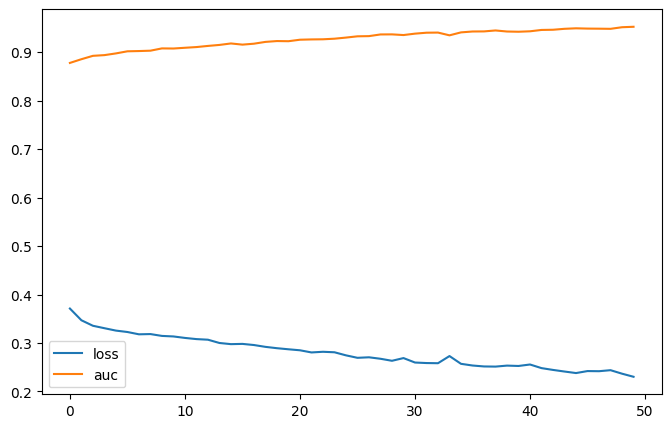

In [59]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

y_pred = model.predict(x_test)
y_class = np.round(y_pred)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

##### Confusion matrix

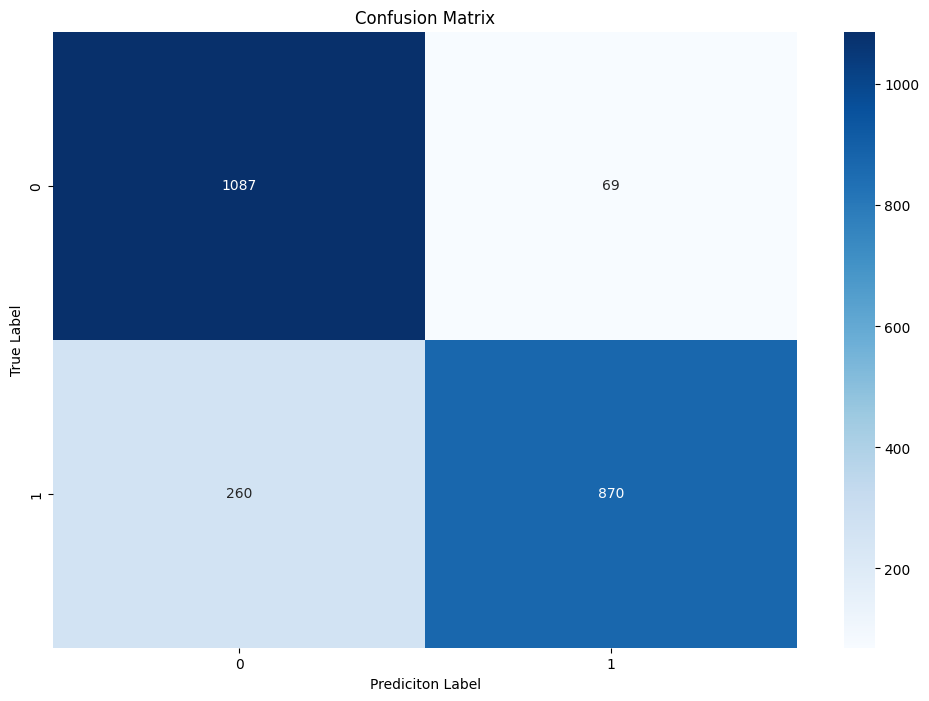

In [60]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

confusion_mtx = confusion_matrix(y_test, y_class)
fig, ax = plt.subplots(figsize=(12,8))
ax = heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap='Blues')
ax.set_xlabel('Prediciton Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.show()

### Making prediction

In [64]:
def model_prediciton(model=model, sentence=''):
    
    sentence = preprocess(sentence)
    sentence = stemming(sentence)
    vectorize_sentence = []
    for word in sentence.split():
        if word in word_list:
            vectorize_sentence.append(word_list[word])
    
    while len(vectorize_sentence) < standard_len:vectorize_sentence.insert(0,0) 
        
    # Normalizing sentence
    vectorize_sentence = np.asarray(vectorize_sentence) / 3440
    
    prediciton = model.predict(vectorize_sentence)
    
    return prediciton

In [65]:
my_sentence = 'I am extremely depressed'

In [66]:
prediction = model_prediciton(model=model, sentence=my_sentence)

if prediction[0][0] > .5:print('Sentence indicate depression with {}% probability'.format(np.round(100*prediction[0][0], 2)))
else:print('Probability of depression is only {}%'.format(np.round(100*prediction[0][0], 2)))

ValueError: in user code:

    File "C:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None
